# YOLOv5

## Preparation

[DEBUG] out[0] shape: (1, 80, 80, 54)
[DEBUG] out[1] shape: (1, 40, 40, 54)
[DEBUG] out[2] shape: (1, 20, 20, 54)
Prediction saved as prediction.jpg


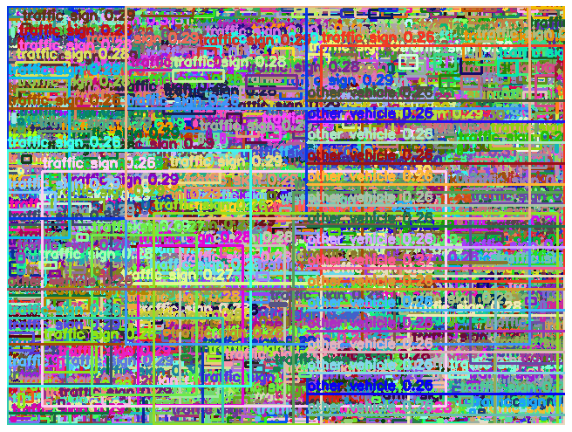

FPS=0.01, total frames = 1, time=109.223797 seconds


In [1]:
import xir
import vart
import time
from typing import List, Tuple
import random
import cv2
import importlib
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Config
# ===============================
DEBUG = True

DEFAULT_YOLOV5_ANCHORS = [
    [[10, 13], [16, 30], [33, 23]],      # P3
    [[30, 61], [62, 45], [59, 119]],     # P4
    [[116, 90], [156, 198], [373, 326]]  # P5
]

# ===============================
# Utils
# ===============================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def xywh2xyxy(x):
    y = np.empty_like(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def bbox_iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_rect_x1 = np.maximum(b1_x1, b2_x1)
    inter_rect_y1 = np.maximum(b1_y1, b2_y1)
    inter_rect_x2 = np.minimum(b1_x2, b2_x2)
    inter_rect_y2 = np.minimum(b1_y2, b2_y2)

    inter_w = np.maximum(0.0, inter_rect_x2 - inter_rect_x1)
    inter_h = np.maximum(0.0, inter_rect_y2 - inter_rect_y1)
    inter_area = inter_w * inter_h

    b1_area = np.maximum(0.0, (b1_x2 - b1_x1)) * np.maximum(0.0, (b1_y2 - b1_y1))
    b2_area = np.maximum(0.0, (b2_x2 - b2_x1)) * np.maximum(0.0, (b2_y2 - b2_y1))
    union = b1_area + b2_area - inter_area + 1e-16
    return inter_area / union

def nms_yolov5(prediction, num_classes, conf_thres=0.25, iou_thres=0.45):
    out = []

    for img_pred in prediction:
        if img_pred is None or img_pred.size == 0:
            out.append(None)
            continue

        obj = 1 / (1 + np.exp(-img_pred[:, 4]))
        cls_logits = img_pred[:, 5:5 + num_classes]
        cls_prob = 1 / (1 + np.exp(-cls_logits))
        cls_conf = np.max(cls_prob, axis=1)
        cls_id = np.argmax(cls_prob, axis=1)

        conf = obj * cls_conf
        keep = conf >= conf_thres
        if not np.any(keep):
            out.append(None)
            continue

        boxes_xywh = img_pred[keep, :4]
        boxes_xyxy = xywh2xyxy(boxes_xywh)
        conf = conf[keep]
        cls_conf = cls_conf[keep]
        cls_id = cls_id[keep]

        order = np.argsort(conf)[::-1]
        boxes_xyxy = boxes_xyxy[order]
        conf = conf[order]
        cls_conf = cls_conf[order]
        cls_id = cls_id[order]

        keep_indices = []
        while boxes_xyxy.shape[0]:
            keep_indices.append(0)
            if boxes_xyxy.shape[0] == 1:
                break
            ious = bbox_iou(boxes_xyxy[[0]], boxes_xyxy[1:])
            keep_mask = ious < iou_thres
            boxes_xyxy = boxes_xyxy[1:][keep_mask]
            conf = conf[1:][keep_mask]
            cls_conf = cls_conf[1:][keep_mask]
            cls_id = cls_id[1:][keep_mask]
            
    outs = []
    for img_pred in prediction:
        if img_pred is None or img_pred.size == 0:
            outs.append(None)
            continue
        obj = 1 / (1 + np.exp(-img_pred[:, 4]))
        cls_logits = img_pred[:, 5:5 + num_classes]
        cls_prob = 1 / (1 + np.exp(-cls_logits))
        cls_conf_all = cls_prob
        conf_all = obj[:, None] * cls_prob
        
        cls_conf = np.max(cls_conf_all, axis=1)
        cls_id = np.argmax(conf_all, axis=1)
        conf = np.max(conf_all, axis=1)

        keep = conf >= conf_thres
        if not np.any(keep):
            outs.append(None)
            continue

        boxes_xyxy = xywh2xyxy(img_pred[keep, :4])
        conf = conf[keep]
        best_cls_conf = cls_conf[keep]
        cls_id = cls_id[keep]

        final_det = []
        for c in np.unique(cls_id):
            idxs = np.where(cls_id == c)[0]
            b = boxes_xyxy[idxs]
            s = conf[idxs]
            cc = best_cls_conf[idxs]
            order = np.argsort(s)[::-1]
            b = b[order]; s = s[order]; cc = cc[order]
            keep_list = []
            while b.shape[0]:
                keep_list.append(0)
                if b.shape[0] == 1:
                    break
                ious = bbox_iou(b[[0]], b[1:])
                mask = ious < iou_thres
                b = b[1:][mask]; s = s[1:][mask]; cc = cc[1:][mask]

            b = boxes_xyxy[idxs][order]
            s = conf[idxs][order]
            cc = best_cls_conf[idxs][order]
            keep_final = []
            while len(b):
                keep_final.append(0)
                if len(b) == 1:
                    break
                ious = bbox_iou(b[[0]], b[1:])
                m = ious < iou_thres
                b = b[1:][m]; s = s[1:][m]; cc = cc[1:][m]
            b = boxes_xyxy[idxs][order]
            s = conf[idxs][order]
            cc = best_cls_conf[idxs][order]
            chosen = []
            used = np.zeros(len(b), dtype=bool)
            for i in range(len(b)):
                if used[i]:
                    continue
                chosen.append(i)
                ious = bbox_iou(b[[i]], b[i+1:]) if i+1 < len(b) else np.array([])
                mask = ious < iou_thres
                used[i] = True
                if i+1 < len(b):
                    used[i+1:] |= ~mask
            for i in chosen:
                final_det.append([b[i,0], b[i,1], b[i,2], b[i,3], s[i], cc[i], float(c)])

        if len(final_det) == 0:
            outs.append(None)
        else:
            outs.append(np.array(final_det, dtype=np.float32))

    return outs

# ===============================
# Decode
# ===============================

def decode_yolov5_feature_map(feat, anchors, img_size: Tuple[int, int]):
    if feat.ndim != 4:
        raise ValueError(f"Feature map must be 4D, got {feat.shape}")

    if feat.shape[1] not in (3*(5+80), 255):
        feat = np.transpose(feat, (0, 3, 1, 2))

    N, C, H, W = feat.shape
    num_anchors = 3

    bbox_attrs = C // num_anchors // 1
    if (C % num_anchors) != 0:
        raise ValueError(f"Channels {C} not divisible by anchors {num_anchors}")
    bbox_attrs = C // num_anchors
    num_classes = bbox_attrs - 5

    feat = feat.reshape(N, num_anchors, bbox_attrs, H, W).transpose(0, 1, 3, 4, 2)

    grid_y, grid_x = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    grid_x = grid_x.reshape(1, 1, H, W, 1).astype(np.float32)
    grid_y = grid_y.reshape(1, 1, H, W, 1).astype(np.float32)

    img_w, img_h = img_size
    stride_x = img_w / W
    stride_y = img_h / H

    anchors = np.array(anchors, dtype=np.float32)
    anchor_w = anchors[:, 0].reshape(1, num_anchors, 1, 1, 1)
    anchor_h = anchors[:, 1].reshape(1, num_anchors, 1, 1, 1)

    px = feat[..., 0:1]
    py = feat[..., 1:2]
    pw = feat[..., 2:3]
    ph = feat[..., 3:4]
    po = feat[..., 4:5]
    pc = feat[..., 5:]

    bx = (sigmoid(px) * 2.0 - 0.5 + grid_x) * stride_x
    by = (sigmoid(py) * 2.0 - 0.5 + grid_y) * stride_y
    bw = (sigmoid(pw) * 2.0) ** 2 * anchor_w
    bh = (sigmoid(ph) * 2.0) ** 2 * anchor_h

    obj = sigmoid(po)
    cls = sigmoid(pc)

    xywh = np.concatenate([bx, by, bw, bh], axis=-1)
    out = np.concatenate([xywh, obj, cls], axis=-1)
    out = out.reshape(N, num_anchors * H * W, 5 + num_classes)
    return out

def collect_predictions(outputData, img_size, config):
    num_classes = config["yolo"]["classes"]
    img_w, img_h = img_size

    ready = []
    fmap = []

    for o in outputData:
        if o.ndim == 3 and o.shape[-1] == (5 + num_classes):
            ready.append(o)
        elif o.ndim == 4:
            fmap.append(o)
        else:
            if o.ndim == 3 and o.shape[1] == (5 + num_classes):
                ready.append(np.transpose(o, (0, 2, 1)))
            else:
                fmap.append(o)

    preds = []
    if ready:
        preds.append(np.concatenate(ready, axis=1))

    if fmap:
        anchors_all = config.get("yolo", {}).get("anchors", DEFAULT_YOLOV5_ANCHORS)
        fmap_sorted = sorted(fmap, key=lambda a: (a.shape[1] if a.ndim==4 and a.shape[1] < a.shape[-1] else a.shape[-2]), reverse=True)
        decoded = []
        for i, feat in enumerate(fmap_sorted):
            if feat.ndim != 4:
                continue
            if feat.shape[-1] >= 3*(5+num_classes):
                H, W = feat.shape[1], feat.shape[2]
            else:
                H, W = feat.shape[2], feat.shape[3]
            anchors = anchors_all[min(i, 2)]
            decoded.append(decode_yolov5_feature_map(feat, anchors, (img_w, img_h)))
        if decoded:
            preds.append(np.concatenate(decoded, axis=1))

    if not preds:
        raise RuntimeError("Could not interpret model outputs.")

    return np.concatenate(preds, axis=1)

# ===============================
# DPU utils
# ===============================

def get_child_subgraph_dpu(graph: "Graph") -> List["Subgraph"]:
    root_subgraph = graph.get_root_subgraph()
    if root_subgraph.is_leaf:
        return []
    child_subgraphs = root_subgraph.toposort_child_subgraph()
    return [cs for cs in child_subgraphs if cs.has_attr("device") and cs.get_attr("device").upper() == "DPU"]

# ===============================
# Inference
# ===============================

def runYolo(dpu_runner, image, config, image_path, orig_hw):
    inputTensors = dpu_runner.get_input_tensors()
    outputTensors = dpu_runner.get_output_tensors()

    runSize = 1
    in_shape = (runSize,) + tuple([inputTensors[0].dims[i] for i in range(1, inputTensors[0].ndim)])
    inputData = [np.empty(in_shape, dtype=np.float32, order='C')]
    inputData[0][0, ...] = image.reshape(in_shape[1:])

    outputData = [np.empty(tuple([runSize] + [t.dims[i] for i in range(1, t.ndim)]),
                           dtype=np.float32, order='C') for t in outputTensors]

    job_id = dpu_runner.execute_async(inputData, outputData)
    dpu_runner.wait(job_id)

    if DEBUG:
        for i, o in enumerate(outputData):
            print(f"[DEBUG] out[{i}] shape: {o.shape}")

    img_size = (config["img_w"], config["img_h"])
    predictions = collect_predictions(outputData, img_size, config)

    dets_list = nms_yolov5(predictions, config["yolo"]["classes"],
                           conf_thres=config["confidence_threshold"], iou_thres=0.45)

    classes = config["class_names"]
    ori_h, ori_w = orig_hw

    for dets in dets_list:
        if dets is None:
            print("No detections above threshold.")
            continue

        sx = ori_w / img_size[0]
        sy = ori_h / img_size[1]

        im = cv2.imread(image_path)
        for x1, y1, x2, y2, conf, cls_conf, cls_id in dets:
            X1 = int(max(0, x1 * sx)); Y1 = int(max(0, y1 * sy))
            X2 = int(min(ori_w - 1, x2 * sx)); Y2 = int(min(ori_h - 1, y2 * sy))

            color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.rectangle(im, (X1, Y1), (X2, Y2), color, 2)
            label = f"{classes[int(cls_id)]} {conf:.2f}"
            cv2.putText(im, label, (X1, max(0, Y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        out_path = "prediction.jpg"
        cv2.imwrite(out_path, im)
        print(f"Prediction saved as {out_path}")

        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(im_rgb)
        plt.axis("off")
        plt.show()

# ===============================
# main
# ===============================

def main(xmodel_file, image_path):
    g = xir.Graph.deserialize(xmodel_file)
    subgraphs = get_child_subgraph_dpu(g)
    assert len(subgraphs) == 1, "Expected one DPU subgraph"

    dpu_runner = vart.Runner.create_runner(subgraphs[0], "run")

    config = importlib.import_module("params").TRAINING_PARAMS
    if "yolo" not in config:
        config["yolo"] = {"classes": 80, "anchors": DEFAULT_YOLOV5_ANCHORS}
    else:
        config["yolo"].setdefault("anchors", DEFAULT_YOLOV5_ANCHORS)

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    ori_h, ori_w = img.shape[:2]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (config["img_w"], config["img_h"]), interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0

    t0 = time.time()
    runYolo(dpu_runner, img, config, image_path, (ori_h, ori_w))
    del dpu_runner
    t1 = time.time()

    fps = 1.0 / (t1 - t0) if (t1 - t0) > 0 else 0.0
    print(f"FPS={fps:.2f}, total frames = 1, time={t1 - t0:.6f} seconds")

main("yolov5.xmodel", "1.jpg")
